In [106]:
from PIL import Image, ImageFilter, ImageStat
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2, glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy
import scipy.misc
import imageio
from skimage.transform import resize
from skimage import data
import PIL
import os
import itertools
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve, KFold, cross_val_score, StratifiedKFold
import sklearn
from sklearn.metrics import confusion_matrix
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
import keras
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D, Activation
from keras.optimizers import RMSprop, SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback, EarlyStopping

from keras import backend as K
%matplotlib inline
os.chdir('/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset')

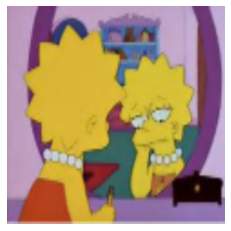

In [107]:
# Plot Image
image_name = "/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/lisa_simpson_18.jpg" #Image to be used as query
def plotLisa(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (512,512))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotLisa(image_name)

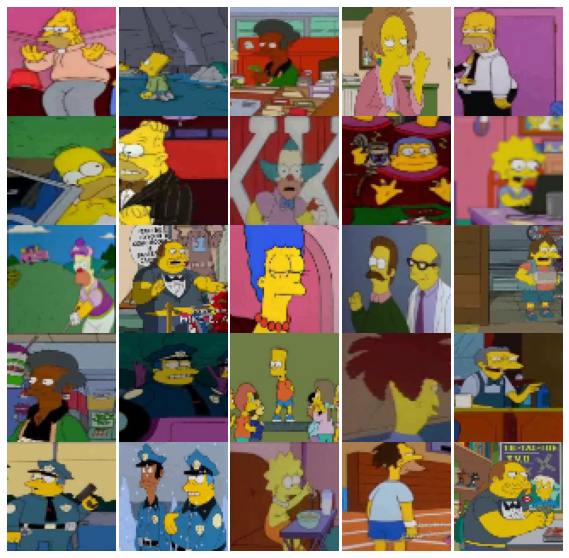

In [108]:
# Plot Multiple Images
simpsons = glob.glob('/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in simpsons[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (64, 64)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

In [109]:
map_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lenny_leonard', 11:'lisa_simpson',
        12: 'marge_simpson', 13: 'mayor_quimby',14:'milhouse_van_houten', 15: 'moe_szyslak', 
        16: 'ned_flanders', 17: 'nelson_muntz', 18: 'principal_skinner', 19: 'sideshow_bob'}

In [110]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [111]:
img_size = 64
# Load and Compress/Resize Test Data
dict_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lenny_leonard', 11:'lisa_simpson',
        12: 'marge_simpson', 13: 'mayor_quimby',14:'milhouse_van_houten', 15: 'moe_szyslak', 
        16: 'ned_flanders', 17: 'nelson_muntz', 18: 'principal_skinner', 19: 'sideshow_bob'}

In [112]:
def load_test_set(dirname,dict_characters):
    X_test = []
    Y_test = []
    for image_name in os.listdir(dirname):
        character_name = "_".join(image_name.split('_')[:-1])
        label = [label for label,character in dict_characters.items() if character == character_name][0]
        image = imageio.imread(dirname+'/'+image_name)
        X_test.append(resize(image,(img_size,img_size)))
        Y_test.append(label)
    return np.array(X_test), np.array(Y_test)
X_test, Y_test = load_test_set("/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset", dict_characters)

In [113]:
from os import listdir
directory_name = "/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset"

In [114]:
def load_train_set(dirname,dict_characters):
   X_train = []
   Y_train = []
   for label,character in dict_characters.items():
       list_images = os.listdir(dirname+'/'+character)
       for image_name in list_images[0:150]:
           image = imageio.imread(dirname+'/'+character+'/'+image_name)
           X_train.append(resize(image,(img_size,img_size)))
           Y_train.append(label)
   return np.array(X_train), np.array(Y_train)
X_train, Y_train = load_train_set("/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset", dict_characters)    

In [115]:
# Split data for cross validation
X_test, Y_test = load_test_set("/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset", dict_characters) 
X_train, Y_train = load_train_set("/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset", dict_characters)       
# Reduce Sample Size for DeBugging 
X_train = X_train[0:3000] 
Y_train = Y_train[0:3000]
X_test = X_test[0:1000] 
Y_test = Y_test[0:1000]
print("Training Data Shape:", X_train.shape, X_train.shape)
print("Testing Data Shape:", X_test.shape, X_test.shape)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 20)
Y_test = to_categorical(Y_test, num_classes = 20)

Training Data Shape: (3000, 64, 64, 3) (3000, 64, 64, 3)
Testing Data Shape: (990, 64, 64, 3) (990, 64, 64, 3)


In [116]:
def runAnotherKerasAugmented(a,b,c,d):
    batch_size = 128
    num_classes = 20
    epochs = 60
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation = "softmax"))
    # Define the optimizer
    optimizer = RMSprop(lr=0.001, decay=1e-6)
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    datagen.fit(a)
    model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs)
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2B - accuracy:', score[1])
    print('')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 

Epoch 1/60
94/93 [==============================] - 4s 41ms/step - loss: 3.7029 - accuracy: 0.0990
Epoch 2/60
94/93 [==============================] - 5s 54ms/step - loss: 3.0928 - accuracy: 0.1247
Epoch 3/60
94/93 [==============================] - 4s 41ms/step - loss: 2.8357 - accuracy: 0.1713
Epoch 4/60
94/93 [==============================] - 4s 43ms/step - loss: 2.6282 - accuracy: 0.2427
Epoch 5/60
94/93 [==============================] - 4s 42ms/step - loss: 2.4429 - accuracy: 0.2910
Epoch 6/60
94/93 [==============================] - 4s 42ms/step - loss: 2.2786 - accuracy: 0.3380
Epoch 7/60
94/93 [==============================] - 4s 45ms/step - loss: 2.1692 - accuracy: 0.3683
Epoch 8/60
94/93 [==============================] - 4s 41ms/step - loss: 2.0551 - accuracy: 0.4043
Epoch 9/60
94/93 [==============================] - 4s 41ms/step - loss: 1.9338 - accuracy: 0.4387
Epoch 10/60
94/93 [==============================] - 5s 53ms/step - loss: 1.8671 - accuracy: 0.4620
Epoch 11/

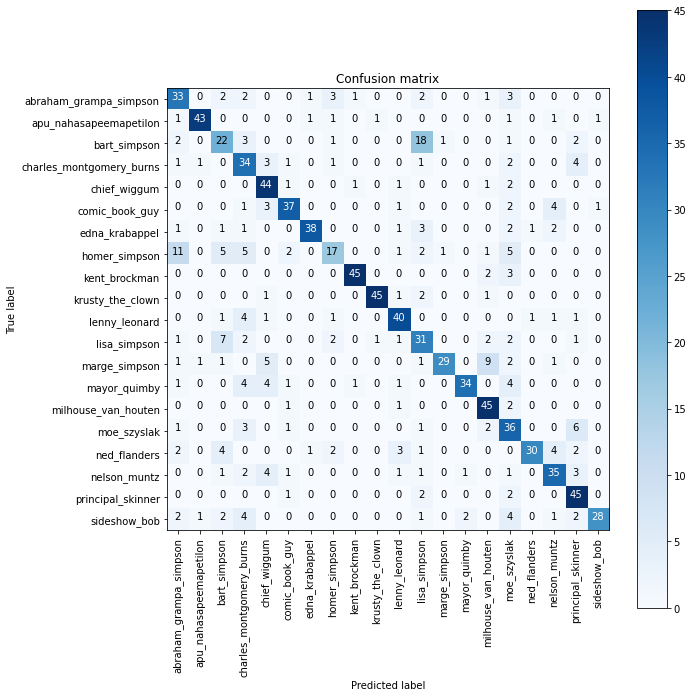

In [117]:
runAnotherKerasAugmented(X_train, Y_train, X_test, Y_test)

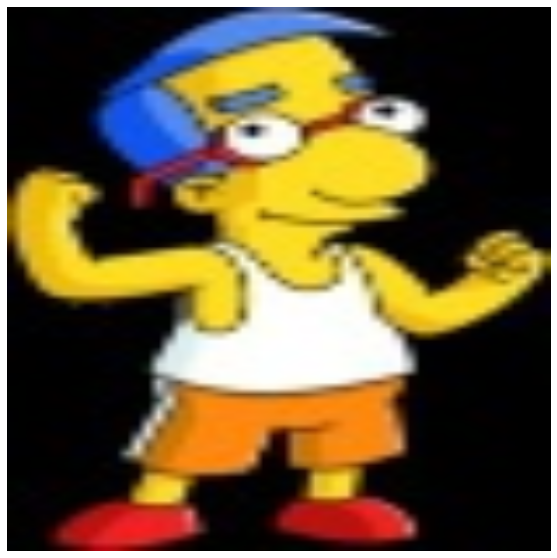

In [118]:
image_name = "/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/milhouse_van_houten_46.jpg" #Image to be used as query
def plotMilhouse(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (512,512))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotMilhouse(image_name)